# 1. VIENNA dataset preprocessing

- load exported patient data from the [Vienna Cirrhosis Study](https://clinicaltrials.gov/ct2/show/NCT03267615)
- initial exploratory data analysis: variables, missing values, ...
- inputation of missing values using different methods

<sub>original notebook name: `VICIS_01_preprocessing.ipynb`</sub>

In [1]:
import pandas as pd                               # data science library
import seaborn as sns                             # visualizations

from sklearn.preprocessing import StandardScaler  # scaling
from sklearn.impute import KNNImputer             # missing values imputation using k-NN

pd.set_option("max_columns", 200)                 # show all columns when printing tables

## Load data

In [ ]:
# load raw dataset
data_raw = pd.read_excel("../VICIS_CeMM-HVPG_201105_orig.xlsx")

In [6]:
# load previously selected parameters (columns) to be further used
columns = pd.read_csv("../VICIS_selected_parameters_v1.txt", header = None, sep = "|")

# list these parameters
columns = list(columns.iloc[:,0])
print(columns)

['#VICIS', 'DATE HVPG', 'SEX', 'SEX_Code', 'AGE', 'INCL45_JIRI-ML_HVPG>5_ACLD-ETIO_NO-NSBB_NO-DOUBLE_NO-OLT_NO-HCC-ooM_NO-AD-ACLF_NO-occlPVT_cACLD_EXCL=0_NO-PSVD_NO-ACTMALIGNANCY', 'ETIO', 'ETIO_Code', 'BL_STIFFNESS', 'MELD-UNOS', 'BL_BMI', 'HVPG', 'HR', 'SYS', 'DIA', 'MAP', 'ERY', 'HB', 'HKT', 'MCV', 'MCH', 'MCHC', 'ERY-DISTRIBUTION', 'PLT', 'MPLTV', 'WBC', 'Na', 'K', 'Cl', 'Ca', 'Ph', 'Mg', 'KREA', 'BUN', 'BILI', 'PROTEIN', 'ALB', 'CHE', 'AP', 'ASAT', 'ALAT', 'GGT', 'LDH', 'aPTT', 'FGEN', 'INR', 'TPZ%', 'TZ', 'D-Dim', 'vWF_Ag', 'aPTT Aktin-FS', 'ADAMTS13-Act', 'PT_F1,2', 'PFA100_EPI', 'Pro_C_Res', 'Pro_C_Act', 'Pro_C_Imm', 'Pro_S_Imm', 'Pro_S_Act', 'AT-III_Act', 'PAI', 'AntiP_Act', 'PLAS_Act', 'F_VIII_Act', 'F_V_Act', 'BA', 'TRIG', 'CHOL', 'GLUC', 'HDL', 'LDL', 'HbA1c', 'HbA1c-IFCC', 'Fe', 'TF', 'TFS', 'FERRITIN', 'sTFR', '%CDT', 'COERULOPLASMIN', 'LACT', 'NH3', 'CRP', 'IL6', 'LBP', 'PCT', 'C3c', 'C4', 'TSH', '25(OH)D', 'PTH', 'LH', 'FSH', 'PRL', '17b-ESTRADIOL', 'TEST', 'BA-TEST', '

In [7]:
# keep only selected parameters
df1 = data_raw[columns]

# keep only records marked as relevant by Benedikt, rename the column
df1 = df1.rename(columns={"INCL45_JIRI-ML_HVPG>5_ACLD-ETIO_NO-NSBB_NO-DOUBLE_NO-OLT_NO-HCC-ooM_NO-AD-ACLF_NO-occlPVT_cACLD_EXCL=0_NO-PSVD_NO-ACTMALIGNANCY": "to_include"})
df1 = df1[df1["to_include"]==1]

# set index based on #VICIS
df1["#VICIS"] = df1["#VICIS"].astype(int)
df1.set_index('#VICIS', inplace=True, drop=True)

# save as Excel file
df1.to_excel("../preprocessed/VICIS_CeMM_preprocessed_v1.xlsx")

## First look at missing data

In [9]:
# number of columns
print("total columns:", df1.shape[1])

# how many columns have missing data
print("columns with missing data:", sum(df1.isnull().sum() > 0))

total columns: 129
columns with missing data: 107


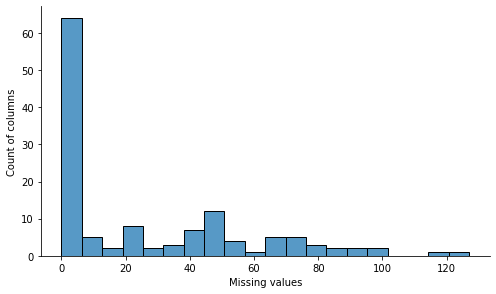

In [10]:
# many columns have missing values
ax = sns.displot(df1.isnull().sum(), bins = 20, height=4, aspect=7/4)
ax.set(xlabel="Missing values", ylabel="Count of columns")

In [8]:
# get columns with more than 1/3 of data missing
missing_data_columns = df1.columns[df1.isnull().sum(axis = 0) > df1.shape[1]/3]

# show how many records are in these columns, sort descending
df1[missing_data_columns].isnull().sum().sort_values(ascending=False)

F_V_Act            127
Pro_S_Act          120
ESTRONE             98
CORTST              96
ESTRONE-SULFATE     95
PROINS              90
FGF23               88
aPTT Aktin-FS       83
Pro_C_Res           82
%CDT                82
C-PEPTIDE           77
ACE                 76
COERULOPLASMIN      76
LACT                75
RBP                 75
Pro_C_Imm           71
ACTH                69
fCORT               68
CBG                 68
17b-ESTRADIOL       67
sCORT               64
TZ                  61
ADN/RENIN           54
IGF-I               54
ADN                 51
STT                 51
C3c                 50
C4                  50
F_VIII_Act          50
PLAS_Act            50
AntiP_Act           50
PAI                 50
ADAMTS13-Act        50
FA                  49
VIT_B12             49
PTH                 49
HbA1c-IFCC          47
HbA1c               47
dtype: int64

In [9]:
# get rid of columns where more than 1/3 of records are missing EXCEPT VWF
to_discard = list(missing_data_columns)

df2 = df1.drop(to_discard, axis=1)
print(df2.shape)

# save as Excel file
df2.to_excel("../preprocessed/VICIS_CeMM_preprocessed_v2.xlsx")

(131, 91)


In [10]:
# for columns where this was not done automatically, change the data type to "numeric"
df2[["ETIO_Code", "PLGF", "proBNP"]] = df2[["ETIO_Code", "PLGF", "proBNP"]].apply(pd.to_numeric)

# list dtypes
print(df2.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 32 to 800
Data columns (total 91 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE HVPG         131 non-null    datetime64[ns]
 1   SEX               131 non-null    object        
 2   SEX_Code          131 non-null    int64         
 3   AGE               131 non-null    float64       
 4   to_include        131 non-null    int64         
 5   ETIO              131 non-null    object        
 6   ETIO_Code         131 non-null    int64         
 7   BL_STIFFNESS      121 non-null    float64       
 8   MELD-UNOS         131 non-null    float64       
 9   BL_BMI            128 non-null    float64       
 10  HVPG              131 non-null    float64       
 11  HR                131 non-null    float64       
 12  SYS               131 non-null    float64       
 13  DIA               131 non-null    float64       
 14  MAP               129 non

## Dealing with missing data

In [11]:
# columns with no missing data
no_missing = ["DATE HVPG", "SEX", "to_include","SEX_Code", "AGE", "ETIO", "ETIO_Code", "HVPG"]

# take all the other columns
X = df2.copy().drop(no_missing, axis=1)

In [12]:
X.shape

(131, 83)

#### Total number of missing fields 

In [13]:
print(f'total: {X.shape[0]*X.shape[1]:,}')
print(f'not missing: {X.count().sum():,}')
print(f'missing: {(X.shape[0]-X.count()).sum():,}')

782/10873*100

total: 10,873
not missing: 10,091
missing: 782


7.192127287777063

### Replace missing values with (column) median

In [ ]:
X_median_used = X.fillna(X.median())

### Impute missing values using k-NN ($k$ nearest neighbors)
- more details: https://towardsdatascience.com/the-use-of-knn-for-missing-values-cf33d935c637
- find records that are most similar, and "borrow" the missing value from them
- parameter $k$ set to 5: information from 5 nearest neighbors used
- in order to find most similar records, scaling needs to be done so that all the columns have the same weight
    - this is removed after imputation

In [15]:
# initialize rescaler for k-NN
scaler = StandardScaler()

# rescale to standard score
X_scaled = pd.DataFrame(scaler.fit_transform(X))

X_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82
0,-1.044838,-0.491969,-1.349691,-1.122194,-1.397311,-1.181226,-1.359017,-0.080497,0.197764,0.490730,1.151831,0.556818,-0.761864,-0.237565,1.375630,0.112238,-0.238946,-0.415575,NaN,NaN,NaN,NaN,NaN,-0.211054,0.574442,-0.186030,-0.016301,0.278242,-0.138901,0.071288,-0.480596,-0.352995,-0.939784,-0.269105,-1.093411,-1.008774,-0.273910,-0.231654,-0.261714,-0.966637,0.360327,-1.049441,0.013707,-0.960332,-0.314932,-0.417768,-1.186802,-0.663478,-0.114566,0.056877,-0.504439,2.187587,-0.341704,2.131307,-0.170600,2.187587,-0.775223,-0.564368,-0.319840,-1.146623,-0.301952,-0.651875,-0.956607,0.924225,-0.010159,-0.504994,1.610706,1.100196,0.766043,0.813384,-0.905778,1.634759,-0.143934,-0.284607,-0.307753,-0.416820,NaN,NaN,0.203969,NaN,NaN,NaN,NaN
1,-0.669536,-0.491969,-0.797819,-0.147496,-0.313695,-0.948767,-0.661821,-0.904633,-0.504382,-0.505386,0.876942,0.707859,-0.016185,0.573479,-0.389500,1.561972,-1.170930,1.678284,NaN,NaN,NaN,NaN,NaN,-0.244007,-0.873598,0.413521,-0.740801,-1.123669,-0.408307,0.267573,0.343484,0.399289,-0.293855,-0.615755,-0.896338,2.368808,-1.345021,1.103116,9.857449,0.868042,0.131147,0.508311,0.094080,-0.105312,0.987190,0.343565,-0.549432,0.689387,-0.833741,2.382412,-0.167708,-0.026096,0.275541,-0.177925,-0.336738,-0.026096,-0.089989,3.689522,0.588806,0.780963,-0.272848,-0.012300,-0.213182,2.848726,2.035859,0.985975,-1.253022,-1.351616,-0.393705,0.120147,1.312935,-1.073334,-0.189848,NaN,-0.165288,-0.471554,NaN,NaN,0.133297,NaN,NaN,NaN,NaN
2,0.814610,0.350488,-1.377848,-0.204831,-0.021952,0.910911,0.225520,0.578812,-0.288337,-0.098808,-1.169452,-1.293433,-0.612728,-0.063770,-0.631773,NaN,-0.816776,-0.415575,NaN,NaN,NaN,NaN,NaN,-0.079240,0.264148,0.531080,1.577599,0.040630,-1.381468,-0.643749,-0.327989,-0.572411,-0.750218,1.018452,2.507666,-0.306624,0.797201,-0.899040,-0.261714,-0.830276,-0.531544,NaN,-0.589088,-1.102835,-0.939951,-0.359524,-0.903526,-0.449868,-0.617989,0.593539,-0.568578,0.132024,0.999207,-0.260625,-0.615365,0.132024,4.797469,-0.548671,0.079556,0.154234,-0.261207,-0.282121,-1.466670,-0.756448,-0.643451,-0.546993,0.269574,0.693746,-0.724711,0.607422,0.834492,-0.640680,0.441307,-0.324249,-0.302273,-0.405297,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.107388,-0.491969,-1.362831,-0.606177,-0.938858,-0.793794,-0.725202,-0.245324,-0.126303,-0.464728,-0.039354,0.179216,0.580357,-0.874813,-1.462422,0.885429,-1.315387,-0.415575,-0.795238,-0.767962,NaN,NaN,NaN,-0.474682,-0.804644,-0.679778,-0.378551,0.848510,-0.336832,-0.980238,0.251920,0.618705,-0.736176,-0.863362,-0.090126,-0.863502,-0.273910,-0.231654,-0.236170,-0.012108,0.644732,0.278479,0.295011,-1.577846,0.466341,-0.704829,-0.856314,-0.046382,-0.402236,0.712797,-0.178398,-0.816697,-1.001517,-0.527809,-0.218019,-0.816697,-0.325280,-0.564368,-0.352305,-0.619960,-0.325234,-0.601908,0.486905,-0.791280,-0.549769,-0.106002,-1.199150,-1.312282,0.015762,-1.721955,-1.514347,0.983107,-0.302834,NaN,-0.245288,-0.001996,NaN,NaN,-0.801143,NaN,NaN,NaN,NaN
4,0.257344,-0.913197,0.805239,0.081845,-0.605438,0.910911,0.288902,0.743639,-0.018281,0.104481,-1.337439,-1.293433,-0.314457,-0.643087,-0.649078,-0.081060,-1.045112,-2.090663,NaN,NaN,NaN,NaN,NaN,0.069052,-0.253009,-0.432904,0.853099,0.587137,-0.171890,-0.769932,-0.816333,-0.415685,-0.525547,-1.135729,-0.090126,-0.766653,-0.809466,1.042445,NaN,-1.437703,-0.592291,1.453177,0.455757,0.417199,-0.314932,-0.467692,2.755449,0.143494,3.193639,-0.420156,-0.274606,-0.757402,-0.554547,-0.597786,-0.253669,-0.757402,-0.482141,-0.548671,-0.331920,-0.351362,-0.313593,0.627276,-0.473214,-0.312332,-0.478570,-0.903985,0.436861,0.431520,-0.123996,NaN,NaN,NaN,-0.289081,-0.358898,-0.339533,-0.134509,0.178887,NaN,-0.895372,-0.20958,2.449539,1.647304,0.700769


In [16]:
# initialize imputer
imputer = KNNImputer(n_neighbors=5)
# impute missing values using kNN with N = 5
X_scaled_kNN_imputed = pd.DataFrame(imputer.fit_transform(X_scaled))

X_scaled_kNN_imputed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82
0,-1.044838,-0.491969,-1.349691,-1.122194,-1.397311,-1.181226,-1.359017,-0.080497,0.197764,0.490730,1.151831,0.556818,-0.761864,-0.237565,1.375630,0.112238,-0.238946,-0.415575,0.018919,0.193467,0.678173,-0.678348,0.313245,-0.211054,0.574442,-0.186030,-0.016301,0.278242,-0.138901,0.071288,-0.480596,-0.352995,-0.939784,-0.269105,-1.093411,-1.008774,-0.273910,-0.231654,-0.261714,-0.966637,0.360327,-1.049441,0.013707,-0.960332,-0.314932,-0.417768,-1.186802,-0.663478,-0.114566,0.056877,-0.504439,2.187587,-0.341704,2.131307,-0.170600,2.187587,-0.775223,-0.564368,-0.319840,-1.146623,-0.301952,-0.651875,-0.956607,0.924225,-0.010159,-0.504994,1.610706,1.100196,0.766043,0.813384,-0.905778,1.634759,-0.143934,-0.284607,-0.307753,-0.416820,0.195010,-0.105715,0.203969,-0.254273,0.338525,0.294530,-0.134679
1,-0.669536,-0.491969,-0.797819,-0.147496,-0.313695,-0.948767,-0.661821,-0.904633,-0.504382,-0.505386,0.876942,0.707859,-0.016185,0.573479,-0.389500,1.561972,-1.170930,1.678284,0.449334,-0.218574,0.625021,0.425174,-0.258768,-0.244007,-0.873598,0.413521,-0.740801,-1.123669,-0.408307,0.267573,0.343484,0.399289,-0.293855,-0.615755,-0.896338,2.368808,-1.345021,1.103116,9.857449,0.868042,0.131147,0.508311,0.094080,-0.105312,0.987190,0.343565,-0.549432,0.689387,-0.833741,2.382412,-0.167708,-0.026096,0.275541,-0.177925,-0.336738,-0.026096,-0.089989,3.689522,0.588806,0.780963,-0.272848,-0.012300,-0.213182,2.848726,2.035859,0.985975,-1.253022,-1.351616,-0.393705,0.120147,1.312935,-1.073334,-0.189848,-0.227934,-0.165288,-0.471554,0.356238,-0.219797,0.133297,-0.250717,1.170824,0.428911,1.006082
2,0.814610,0.350488,-1.377848,-0.204831,-0.021952,0.910911,0.225520,0.578812,-0.288337,-0.098808,-1.169452,-1.293433,-0.612728,-0.063770,-0.631773,-0.023071,-0.816776,-0.415575,-0.089981,-0.081227,-0.260836,-0.208329,0.177052,-0.079240,0.264148,0.531080,1.577599,0.040630,-1.381468,-0.643749,-0.327989,-0.572411,-0.750218,1.018452,2.507666,-0.306624,0.797201,-0.899040,-0.261714,-0.830276,-0.531544,1.453177,-0.589088,-1.102835,-0.939951,-0.359524,-0.903526,-0.449868,-0.617989,0.593539,-0.568578,0.132024,0.999207,-0.260625,-0.615365,0.132024,4.797469,-0.548671,0.079556,0.154234,-0.261207,-0.282121,-1.466670,-0.756448,-0.643451,-0.546993,0.269574,0.693746,-0.724711,0.607422,0.834492,-0.640680,0.441307,-0.324249,-0.302273,-0.405297,0.323993,0.169981,0.323326,0.127141,-0.357581,-0.749167,-0.279009
3,-1.107388,-0.491969,-1.362831,-0.606177,-0.938858,-0.793794,-0.725202,-0.245324,-0.126303,-0.464728,-0.039354,0.179216,0.580357,-0.874813,-1.462422,0.885429,-1.315387,-0.415575,-0.795238,-0.767962,-0.012796,0.149293,0.476677,-0.474682,-0.804644,-0.679778,-0.378551,0.848510,-0.336832,-0.980238,0.251920,0.618705,-0.736176,-0.863362,-0.090126,-0.863502,-0.273910,-0.231654,-0.236170,-0.012108,0.644732,0.278479,0.295011,-1.577846,0.466341,-0.704829,-0.856314,-0.046382,-0.402236,0.712797,-0.178398,-0.816697,-1.001517,-0.527809,-0.218019,-0.816697,-0.325280,-0.564368,-0.352305,-0.619960,-0.325234,-0.601908,0.486905,-0.791280,-0.549769,-0.106002,-1.199150,-1.312282,0.015762,-1.721955,-1.514347,0.983107,-0.302834,-0.342161,-0.245288,-0.001996,-0.266104,-0.117124,-0.801143,-0.170473,-0.357581,-0.166847,-0.009778
4,0.257344,-0.913197,0.805239,0.081845,-0.605438,0.910911,0.288902,0.743639,-0.018281,0.104481,-1.337439,-1.293433,-0.314457,-0.643087,-0.649078,-0.081060,-1.045112,-2.090663,0.075962,-0.630615,-0.189967,-0.606824,0.776303,0.069052,-0.253009,-0.432904,0.853099,0.587137,-0.171890,-0.769932,-0.816333,-0.415685,-0.525547,-1.135729,-0.090126,-0.766653,-0.809466,1.042445,-0.243468,-1.437703,-0.592291,1.453177,0.455757,0.417199,-0.314932,-0.467692,2.755449,0.143494,3.193639,-0.420156,-0.274606,-0.757402,-0.554547,-0.597786,-0.253669,-0.757402,-

In [17]:
# inverse transform to original scales
X_kNN_imputed = pd.DataFrame(scaler.inverse_transform(X_scaled_kNN_imputed), index=X.index, columns = X.columns)

## One-hot encoding of ETIO_Code
- explanation: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
- for each possible value, one column is created
- for each record, the column corresponding to the value is set to 1, other to 0

In [19]:
set(df2.ETIO_Code.values)

{1, 2, 3, 4, 5, 6}

In [20]:
df2.groupby(['ETIO','ETIO_Code']).size()

ETIO                    ETIO_Code
AIH                     6             4
ALD                     1            22
ALD/DILI-MTX-PSORIASIS  1             1
ALD/HIV                 1             1
ALD/KRYPT               1             1
ALD/NASH                1             1
ASH/NASH lt Histo 2010  6             1
BASH                    6             2
HBV                     2             2
HBV/ALD                 2             1
HBV/HDV                 2             4
HBV/HDV/ALD             3             1
HBV/HDV/HIV             2             1
HBV/HIV                 2             1
HBV/NASH                6             1
HCV                     2             9
HCV-SVR                 2            20
HCV-SVR/ALD             3             3
HCV-SVR/HIV             2             1
HCV/ALD                 3             4
HCV/ALD/HIV             3             1
HCV/HIV                 2             2
HCV/HIV/ALD             2             1
HCV/NAFLD               6             1
HFE   

In [ ]:
# perform one-hot encoding
one_hot = pd.get_dummies(df2.ETIO_Code)

# rename columns (ALD=1; VIRAL=2; MIX=3; NASH=4; CHOL=5; OTHER=6)
one_hot.columns = ["ALD", "VIRAL", "MIX", "NASH", "CHOL", "OTHER"]

# check the result on a small subset
pd.concat([df2[["ETIO", "ETIO_Code"]], one_hot], axis=1).head()

## Merge everything back into one table, create categorical label and save
### Merge

In [ ]:
# put columns which are neither predictors nor predicted first, then the dependent variable
df3 = df2[["DATE HVPG", "SEX", "ETIO", "HVPG"]].copy()

# merge with sex and age and one-hot encoded etiology code
df3 = pd.concat([df3, one_hot, df2[["SEX_Code", "AGE"]]], axis=1)

df3.head()

### Create categorical label (two variables, one text, the other binary)

In [ ]:
# HVPG >= 16 "high-risk", otherwise "low-risk"
label = pd.cut(df3['HVPG'], bins=[0, 15.9, float('Inf')], labels=['low-risk', 'high-risk'])
# binary variable, 0 = low-risk, 1 = high-risk
label_binary = pd.cut(df3['HVPG'], bins=[0, 15.9, float('Inf')], labels=[0, 1])

df3.insert(4, 'HVPG_label', label)
df3.insert(5, 'HVPG_label_code', label_binary)

df3.sample(random_state = 42, n = 5)

In [24]:
# merge with the rest of predictor variables
df3a = pd.concat([df3, X], axis=1)               # Version A: missing values kept
df3b = pd.concat([df3, X_median_used], axis=1)   # Version B: missing values replaced with median
df3c = pd.concat([df3, X_kNN_imputed], axis=1)   # Version C: k-NN imputation of missing values

# create Excel file, each version in a separate sheet
writer = pd.ExcelWriter("../preprocessed/VICIS_CeMM_preprocessed_v3.xlsx")
df3a.to_excel(writer,'original_missing')
df3b.to_excel(writer,'median_used') 
df3c.to_excel(writer,'kNN_imputed')
writer.save()

# save as separate "pickle" files which can be quickly loaded into pandas
df3a.to_pickle("../preprocessed/VICIS_CeMM_preprocessed_v3_missing_kept.pickle")
df3b.to_pickle("../preprocessed/VICIS_CeMM_preprocessed_v3_median_replaced.pickle")
df3c.to_pickle("../preprocessed/VICIS_CeMM_preprocessed_v3_knn_imputed.pickle")